# Question 1: AC-GAN

# Part B

# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import torch.optim as optim
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Importing the CIFAR-10 Dataset

In [3]:
tf = transforms.Compose([transforms.Resize(64),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ])

In [4]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = tf)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True,transform = tf)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
dataset = torch.utils.data.ConcatDataset([trainset, testset])
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 100, num_workers = 2, shuffle = True)

In [6]:
print(len(dataset))
print(dataset[0][0].size())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'fake')

60000
torch.Size([3, 64, 64])


In [7]:
!mkdir result

In [8]:
def showImage(images,epoch=-99, idx = -99):
    images = images.cpu().numpy()
    images = images/2 + 0.5
    plt.imshow(np.transpose(images,axes = (1,2,0)))
    plt.axis('off')
    if epoch!=-99:
        plt.savefig("result/e" + str(epoch) + "i" + str(idx) + ".png")

torch.Size([100, 3, 64, 64])


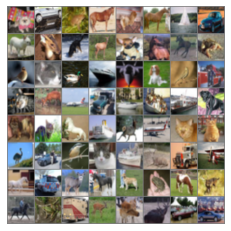

In [9]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
print(images.size())
showImage(make_grid(images[0:64]))

# Defining Generator

In [14]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()
        
        #input 100*1*1
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(100,512,4,1,0,bias = False),
                                   nn.ReLU(True))

        #input 512*4*4
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512,256,4,2,1,bias = False),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(True))
        #input 256*8*8
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256,128,4,2,1,bias = False),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(True))
        #input 128*16*16
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(128,64,4,2,1,bias = False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(True))
        #input 64*32*32
        self.layer5 = nn.Sequential(nn.ConvTranspose2d(64,3,4,2,1,bias = False),
                                   nn.Tanh())
        #output 3*64*64
      
        self.embedding = nn.Embedding(10,100)
        
        
    def forward(self,noise,label):
        
        label_embedding = self.embedding(label)
        x = torch.mul(noise,label_embedding)
        x = x.view(-1,100,1,1)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

# Discriminator Definition

In [15]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()        
        
        #input 3*64*64
        self.layer1 = nn.Sequential(nn.Conv2d(3,64,4,2,1,bias = False),
                                    nn.BatchNorm2d(64),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        
        #input 64*32*32
        self.layer2 = nn.Sequential(nn.Conv2d(64,128,4,2,1,bias = False),
                                    nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        #input 128*16*16
        self.layer3 = nn.Sequential(nn.Conv2d(128,256,4,2,1,bias = False),
                                    nn.BatchNorm2d(256),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        #input 256*8*8
        self.layer4 = nn.Sequential(nn.Conv2d(256,512,4,2,1,bias = False),
                                    nn.BatchNorm2d(512),
                                   nn.LeakyReLU(0.2,True))
        #input 512*4*4
        self.validity_layer = nn.Sequential(nn.Conv2d(512,1,4,1,0,bias = False),
                                   nn.Sigmoid())
        
        self.label_layer = nn.Sequential(nn.Conv2d(512,11,4,1,0,bias = False),
                                   nn.LogSoftmax(dim = 1))
        
    def forward(self,x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        validity = self.validity_layer(x)
        plabel = self.label_layer(x)
        
        validity = validity.view(-1)
        plabel = plabel.view(-1,11)
        
        return validity,plabel

In [16]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [28]:
gen = Generator().to(device)
gen.apply(weights_init)

disc = Discriminator().to(device)
disc.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), pa

In [29]:
paramsG = list(gen.parameters())
print(len(paramsG))

paramsD = list(disc.parameters())
print(len(paramsD))        
        
optimG = optim.Adam(gen.parameters(), 0.0002, betas = (0.5,0.999))
optimD = optim.Adam(disc.parameters(), 0.0002, betas = (0.5,0.999))

validity_loss = nn.BCELoss()

real_labels = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)
epochs = 50

12
14


Streaming output truncated to the last 5000 lines.
[42/50] [402/600] D_x: [0.6091] D_G: [0.4834/0.4067] G_loss: [2.9084] D_loss: [3.4123] D_label: [4.0382] 
[42/50] [403/600] D_x: [0.7558] D_G: [0.5038/0.3439] G_loss: [3.2635] D_loss: [3.3133] D_label: [4.2309] 
[42/50] [404/600] D_x: [0.5313] D_G: [0.2676/0.3775] G_loss: [3.0266] D_loss: [3.2794] D_label: [4.0458] 
[42/50] [405/600] D_x: [0.5428] D_G: [0.4202/0.4692] G_loss: [2.1826] D_loss: [3.7329] D_label: [3.8943] 
[42/50] [406/600] D_x: [0.7089] D_G: [0.5043/0.3319] G_loss: [3.6589] D_loss: [3.0453] D_label: [4.6195] 
[42/50] [407/600] D_x: [0.6236] D_G: [0.4111/0.3804] G_loss: [3.1731] D_loss: [2.8247] D_label: [3.9556] 
[42/50] [408/600] D_x: [0.6228] D_G: [0.4180/0.4488] G_loss: [2.8122] D_loss: [2.9947] D_label: [3.9778] 
[42/50] [409/600] D_x: [0.7877] D_G: [0.4731/0.3974] G_loss: [2.9125] D_loss: [3.0373] D_label: [3.6494] 
[42/50] [410/600] D_x: [0.5347] D_G: [0.4380/0.3771] G_loss: [3.0246] D_loss: [3.6788] D_label: [4.38

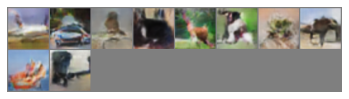

In [30]:
%%time
loss_disc = []
loss_gen = []
for epoch in range(1,epochs+1):

    for idx, (images,labels) in enumerate(trainloader,0):
        batch_size = images.size(0)
        labels= labels.to(device)
        images = images.to(device)
        
        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]
        
        fake_class_labels = 10*torch.ones((batch_size,),dtype = torch.long,device = device)
        
        if idx % 25 == 0:
            real_label, fake_label = fake_label, real_label
        
        # ---------------------
        #         disc
        # ---------------------
        
        optimD.zero_grad()       
        
        # real
        validity_label = torch.full((batch_size,),real_label , device = device)
   
        pvalidity, plabels = disc(images)       
        
        errD_real_val = validity_loss(pvalidity, validity_label)            
        errD_real_label = F.nll_loss(plabels,labels)
        
        errD_real = errD_real_val + errD_real_label
        errD_real.backward()
        
        D_x = pvalidity.mean().item()        
        
        #fake 
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        fakes = gen(noise,sample_labels)
        
        validity_label.fill_(fake_label)
        
        pvalidity, plabels = disc(fakes.detach())       
        
        errD_fake_val = validity_loss(pvalidity, validity_label)
        errD_fake_label = F.nll_loss(plabels, fake_class_labels)
        
        errD_fake = errD_fake_val + errD_fake_label
        errD_fake.backward()
        
        D_G_z1 = pvalidity.mean().item()
        
        #finally update the params!
        errD = errD_real + errD_fake
        
        optimD.step()
    
        
        # ------------------------
        #      gen
        # ------------------------
        
        
        optimG.zero_grad()
        
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        validity_label.fill_(1)
        
        fakes = gen(noise,sample_labels)
        pvalidity,plabels = disc(fakes)
        
        errG_val = validity_loss(pvalidity, validity_label)        
        errG_label = F.nll_loss(plabels, sample_labels)
        
        errG = errG_val + errG_label
        errG.backward()
        
        D_G_z2 = pvalidity.mean().item()
        
        optimG.step()
        
        
        print("[{}/{}] [{}/{}] D_x: [{:.4f}] D_G: [{:.4f}/{:.4f}] G_loss: [{:.4f}] D_loss: [{:.4f}] D_label: [{:.4f}] "
              .format(epoch,epochs, idx, len(trainloader),D_x, D_G_z1,D_G_z2,errG,errD,
                      errD_real_label + errD_fake_label + errG_label))
        
        if idx % 100 == 0:
            noise = torch.randn(10,100,device = device)  
            labels = torch.arange(0,10,dtype = torch.long,device = device)
            
            gen_images = gen(noise,labels).detach()
            
            showImage(make_grid(gen_images),epoch,idx)
      
    loss_disc.append(errD)
    loss_gen.append(errG)
       
    
torch.save(gen.state_dict(),'gen.pth')
torch.save(disc.state_dict(),'disc.pth')

## Plotting the loss

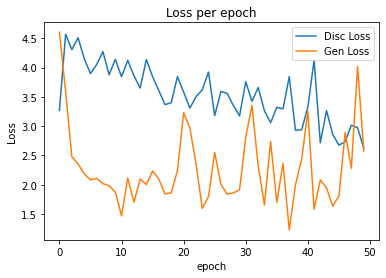

In [ ]:
plt.plot(loss_disc)
plt.plot(loss_gen)
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Disc Loss', 'Gen Loss'], loc='upper right')
plt.show()

# Part C: Trying different optimizer

## Adam
In part B, I used adam as the optimizer.

## RMSprop

In [ ]:
gen = Generator().to(device)
gen.apply(weights_init)

disc = Discriminator().to(device)
disc.apply(weights_init)

paramsG = list(gen.parameters())
print(len(paramsG))

paramsD = list(disc.parameters())
print(len(paramsD))        

optimG = optim.RMSprop(gen.parameters(), lr=0.0005)
optimD = optim.RMSprop(disc.parameters(), lr=0.0005)

validity_loss = nn.BCELoss()

real_labels = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)
epochs = 50

12
14


Streaming output truncated to the last 5000 lines.
[42/50] [402/600] D_x: [0.5764] D_G: [0.4155/0.6090] G_loss: [1.6033] D_loss: [3.4098] D_label: [3.3090] 
[42/50] [403/600] D_x: [0.7014] D_G: [0.6626/0.4414] G_loss: [2.7773] D_loss: [3.7021] D_label: [4.3716] 
[42/50] [404/600] D_x: [0.5330] D_G: [0.4928/0.5484] G_loss: [1.9829] D_loss: [3.9940] D_label: [3.9770] 
[42/50] [405/600] D_x: [0.6414] D_G: [0.6109/0.5020] G_loss: [2.3433] D_loss: [3.8117] D_label: [4.1602] 
[42/50] [406/600] D_x: [0.6721] D_G: [0.6348/0.4389] G_loss: [2.8089] D_loss: [3.8279] D_label: [4.3606] 
[42/50] [407/600] D_x: [0.5290] D_G: [0.4818/0.5745] G_loss: [1.7124] D_loss: [3.9275] D_label: [3.6789] 
[42/50] [408/600] D_x: [0.6211] D_G: [0.4756/0.5250] G_loss: [2.1498] D_loss: [3.0982] D_label: [3.4290] 
[42/50] [409/600] D_x: [0.6725] D_G: [0.5803/0.5488] G_loss: [1.9836] D_loss: [3.2157] D_label: [3.4144] 
[42/50] [410/600] D_x: [0.6412] D_G: [0.5874/0.3894] G_loss: [3.0512] D_loss: [3.8453] D_label: [4.51

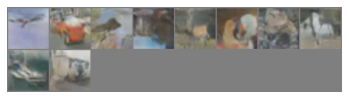

In [ ]:
%%time
loss_disc = []
loss_gen = []
for epoch in range(1,epochs+1):

    for idx, (images,labels) in enumerate(trainloader,0):
        batch_size = images.size(0)
        labels= labels.to(device)
        images = images.to(device)
        
        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]
        
        fake_class_labels = 10*torch.ones((batch_size,),dtype = torch.long,device = device)
        
        if idx % 25 == 0:
            real_label, fake_label = fake_label, real_label
        
        # ---------------------
        #         disc
        # ---------------------
        
        optimD.zero_grad()       
        
        # real
        validity_label = torch.full((batch_size,),real_label , device = device)
   
        pvalidity, plabels = disc(images)       
        
        errD_real_val = validity_loss(pvalidity, validity_label)            
        errD_real_label = F.nll_loss(plabels,labels)
        
        errD_real = errD_real_val + errD_real_label
        errD_real.backward()
        
        D_x = pvalidity.mean().item()        
        
        #fake 
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        fakes = gen(noise,sample_labels)
        
        validity_label.fill_(fake_label)
        
        pvalidity, plabels = disc(fakes.detach())       
        
        errD_fake_val = validity_loss(pvalidity, validity_label)
        errD_fake_label = F.nll_loss(plabels, fake_class_labels)
        
        errD_fake = errD_fake_val + errD_fake_label
        errD_fake.backward()
        
        D_G_z1 = pvalidity.mean().item()
        
        #finally update the params!
        errD = errD_real + errD_fake
        
        optimD.step()
    
        
        # ------------------------
        #      gen
        # ------------------------
        
        
        optimG.zero_grad()
        
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        validity_label.fill_(1)
        
        fakes = gen(noise,sample_labels)
        pvalidity,plabels = disc(fakes)
        
        errG_val = validity_loss(pvalidity, validity_label)        
        errG_label = F.nll_loss(plabels, sample_labels)
        
        errG = errG_val + errG_label
        errG.backward()
        
        D_G_z2 = pvalidity.mean().item()
        
        optimG.step()
        
        
        print("[{}/{}] [{}/{}] D_x: [{:.4f}] D_G: [{:.4f}/{:.4f}] G_loss: [{:.4f}] D_loss: [{:.4f}] D_label: [{:.4f}] "
              .format(epoch,epochs, idx, len(trainloader),D_x, D_G_z1,D_G_z2,errG,errD,
                      errD_real_label + errD_fake_label + errG_label))
        
        if idx % 100 == 0:
            noise = torch.randn(10,100,device = device)  
            labels = torch.arange(0,10,dtype = torch.long,device = device)
            
            gen_images = gen(noise,labels).detach()
            
            showImage(make_grid(gen_images),epoch,idx)
      
    loss_disc.append(errD)
    loss_gen.append(errG)
       
    
torch.save(gen.state_dict(),'gen.pth')
torch.save(disc.state_dict(),'disc.pth')

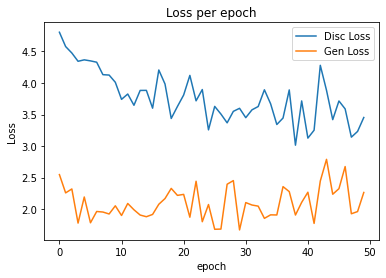

In [ ]:
plt.plot(loss_disc)
plt.plot(loss_gen)
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Disc Loss', 'Gen Loss'], loc='upper right')
plt.show()

# Bonus: U-Net Model as generator

## Block

The contractive path consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.



In [11]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

## Encoder
Each block is followed by a 2x2 max pooling operation with stride 2 for downsampling.

In [12]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

## Decoder
Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.

In [32]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], 
                                                            chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

## Unet

In [24]:
class UNet_Generator(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64),
                 num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, (572,572))
        return out

In [25]:
gen = UNet_Generator().to(device)
gen.apply(weights_init)

disc = Discriminator().to(device)
disc.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), pa

In [26]:
paramsG = list(gen.parameters())
print(len(paramsG))

paramsD = list(disc.parameters())
print(len(paramsD))        
        
optimG = optim.Adam(gen.parameters(), 0.0002, betas = (0.5,0.999))
optimD = optim.Adam(disc.parameters(), 0.0002, betas = (0.5,0.999))

validity_loss = nn.BCELoss()

real_labels = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)
epochs = 50

46
14


Streaming output truncated to the last 5000 lines.
[42/50] [402/600] D_x: [0.5764] D_G: [0.4155/0.6090] G_loss: [1.6033] D_loss: [3.4098] D_label: [3.3090] 
[42/50] [403/600] D_x: [0.7014] D_G: [0.6626/0.4414] G_loss: [2.7773] D_loss: [3.7021] D_label: [4.3716] 
[42/50] [404/600] D_x: [0.5330] D_G: [0.4928/0.5484] G_loss: [1.9829] D_loss: [3.9940] D_label: [3.9770] 
[42/50] [405/600] D_x: [0.6414] D_G: [0.6109/0.5020] G_loss: [2.3433] D_loss: [3.8117] D_label: [4.1602] 
[42/50] [406/600] D_x: [0.6721] D_G: [0.6348/0.4389] G_loss: [2.8089] D_loss: [3.8279] D_label: [4.3606] 
[42/50] [407/600] D_x: [0.5290] D_G: [0.4818/0.5745] G_loss: [1.7124] D_loss: [3.9275] D_label: [3.6789] 
[42/50] [408/600] D_x: [0.6211] D_G: [0.4756/0.5250] G_loss: [2.1498] D_loss: [3.0982] D_label: [3.4290] 
[42/50] [409/600] D_x: [0.6725] D_G: [0.5803/0.5488] G_loss: [1.9836] D_loss: [3.2157] D_label: [3.4144] 
[42/50] [410/600] D_x: [0.6412] D_G: [0.5874/0.3894] G_loss: [3.0512] D_loss: [3.8453] D_label: [4.51

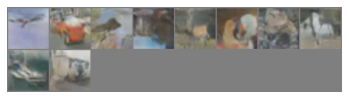

In [ ]:
%%time
loss_disc = []
loss_gen = []
for epoch in range(1,epochs+1):

    for idx, (images,labels) in enumerate(trainloader,0):
        batch_size = images.size(0)
        labels= labels.to(device)
        images = images.to(device)
        
        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]
        
        fake_class_labels = 10*torch.ones((batch_size,),dtype = torch.long,device = device)
        
        if idx % 25 == 0:
            real_label, fake_label = fake_label, real_label
        
        # ---------------------
        #         disc
        # ---------------------
        
        optimD.zero_grad()       
        
        # real
        validity_label = torch.full((batch_size,),real_label , device = device)
   
        pvalidity, plabels = disc(images)       
        
        errD_real_val = validity_loss(pvalidity, validity_label)            
        errD_real_label = F.nll_loss(plabels,labels)
        
        errD_real = errD_real_val + errD_real_label
        errD_real.backward()
        
        D_x = pvalidity.mean().item()        
        
        #fake 
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        fakes = gen(noise,sample_labels)
        
        validity_label.fill_(fake_label)
        
        pvalidity, plabels = disc(fakes.detach())       
        
        errD_fake_val = validity_loss(pvalidity, validity_label)
        errD_fake_label = F.nll_loss(plabels, fake_class_labels)
        
        errD_fake = errD_fake_val + errD_fake_label
        errD_fake.backward()
        
        D_G_z1 = pvalidity.mean().item()
        
        #finally update the params!
        errD = errD_real + errD_fake
        
        optimD.step()
    
        
        # ------------------------
        #      gen
        # ------------------------
        
        
        optimG.zero_grad()
        
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        validity_label.fill_(1)
        
        fakes = gen(noise,sample_labels)
        pvalidity,plabels = disc(fakes)
        
        errG_val = validity_loss(pvalidity, validity_label)        
        errG_label = F.nll_loss(plabels, sample_labels)
        
        errG = errG_val + errG_label
        errG.backward()
        
        D_G_z2 = pvalidity.mean().item()
        
        optimG.step()
        
        
        print("[{}/{}] [{}/{}] D_x: [{:.4f}] D_G: [{:.4f}/{:.4f}] G_loss: [{:.4f}] D_loss: [{:.4f}] D_label: [{:.4f}] "
              .format(epoch,epochs, idx, len(trainloader),D_x, D_G_z1,D_G_z2,errG,errD,
                      errD_real_label + errD_fake_label + errG_label))
        
        if idx % 100 == 0:
            noise = torch.randn(10,100,device = device)  
            labels = torch.arange(0,10,dtype = torch.long,device = device)
            
            gen_images = gen(noise,labels).detach()
            
            showImage(make_grid(gen_images),epoch,idx)
      
    loss_disc.append(errD)
    loss_gen.append(errG)
       
    
torch.save(gen.state_dict(),'gen.pth')
torch.save(disc.state_dict(),'disc.pth')

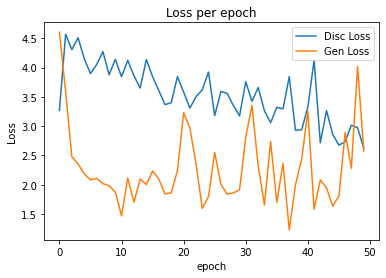

In [ ]:
plt.plot(loss_disc)
plt.plot(loss_gen)
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Disc Loss', 'Gen Loss'], loc='upper right')
plt.show()

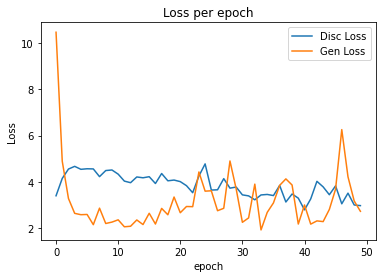

In [ ]:
plt.plot(loss_disc)
plt.plot(loss_gen)
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Disc Loss', 'Gen Loss'], loc='upper right')
plt.show()